# Houses prices competition

This notebook builds a predictive model for predict the sales price of houses, based on data provided on the [House Prices: Advanced Regression Techniques competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview).

In [124]:
# Load dependencies.
import numpy as np
import pandas as pd

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

## 1. Load and clean data

In [125]:
# Load train and test data.
test_data_raw = pd.read_csv('./data/test.csv', sep=',')
train_data_raw = pd.read_csv('./data/train.csv', sep=',')

# Take a quick look into the data.
train_data_raw.head(8)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000


In [126]:
# Categorical columns that can't be directly used for regression.
USELESS_COLUMNS = [
    'Id', 'MSSubClass', 'MiscFeature', 'MoSold', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 
    'MasVnrType', 'Heating', 'Electrical', 'GarageType', 'SaleType', 'SaleCondition', 'Neighborhood'
]

# Table for convert categorical columns that represent score-like values to numbers.
SCORES_TO_NUMBERS = {
    "Alley": {"Grvl": 1, "Pave": 2},
    "Street": {"Grvl": 1, "Pave": 2},
    
    "BsmtCond": {"Ex": 6, "Gd": 5, "TA": 4, "Fa": 3, "Po": 2, "No": 1},
    "BsmtQual": {"Ex": 6, "Gd": 5, "TA": 4, "Fa": 3, "Po": 2, "No": 1},
    "ExterCond": {"Ex": 6, "Gd": 5, "TA": 4, "Fa": 3, "Po": 2, "No": 1},
    "ExterQual": {"Ex": 6, "Gd": 5, "TA": 4, "Fa": 3, "Po": 2, "No": 1},
    "FireplaceQu": {"Ex": 6, "Gd": 5, "TA": 4, "Fa": 3, "Po": 2, "No": 1},
    "GarageCond": {"Ex": 6, "Gd": 5, "TA": 4, "Fa": 3, "Po": 2, "No": 1},
    "GarageQual": {"Ex": 6, "Gd": 5, "TA": 4, "Fa": 3, "Po": 2, "No": 1},
    "HeatingQC": {"Ex": 6, "Gd": 5, "TA": 4, "Fa": 3, "Po": 2, "No": 1},
    "KitchenQual": {"Ex": 6, "Gd": 5, "TA": 4, "Fa": 3, "Po": 2, "No": 1},
    "PoolQC": {"Ex": 6, "Gd": 5, "TA": 4, "Fa": 3, "Po": 2, "No": 1},

    "BsmtExposure": {"Gd": 5, "Av": 4, "Mn": 2, "No": 1},

    "BsmtFinType1": {"GLQ": 6, "ALQ": 4, "BLQ": 4, "Rec": 3, "LwQ": 2, "Unf": 1},
    "BsmtFinType2": {"GLQ": 6, "ALQ": 4, "BLQ": 4, "Rec": 3, "LwQ": 2, "Unf": 1},
    
    "Condition1": {"PosA": 7, "PosN": 6, "Norm": 5, "Feedr": 4, "Artery": 3, "RRNn": 2, "RRNe": 2, "RRAn": 1, "RRAe": 1},
    "Condition2": {"PosA": 7, "PosN": 6, "Norm": 5, "Feedr": 4, "Artery": 3, "RRNn": 2, "RRNe": 2, "RRAn": 1, "RRAe": 1},

    "BldgType": {"1Fam": 1, "2FmCon": 2, "2fmCon": 2, "Duplx": 3, "Duplex": 3, "Twnhs": 4.5, "TwnhsI": 4, "TwnhsE": 5},
    "CentralAir": {"N": 0, "Y": 1},
    "Fence": { "MnWw": 1, "GdWo": 2, "MnPrv": 3, "GdPrv": 4},
    "Foundation": {"BrkTil": 0, "CBlock": 1, "PConc": 2, "Slab": 3, "Stone": 4, "Wood": 5},
    "Functional": {"Typ": 7, "Min1": 6, "Min2": 5, "Mod": 4, "Maj1": 3, "Maj2": 2, "Sev": 1, "Sal": 0},
    "GarageFinish": {"Fin": 3, "RFn": 2, "Unf": 1},
    "HouseStyle": {"SFoyer": 0, "SLvl": 1, "1Story": 2, "1.5Unf": 3, "1.5Fin": 4, "2Story": 5, "2.5Unf": 6, "2.5Fin": 7},
    "LandContour": {"Lvl": 0, "Bnk": 1, "HLS": 2, "Low": -1},
    "LandSlope": {"Gtl": 1, "Mod": 0, "Sev": -1},
    "LotConfig": {"Inside": 0, "Corner": 1, "CulDSac": 2, "FR2": 3, "FR3": 4},
    "LotShape": {"Reg": 4, "IR1": 3, "IR2": 2, "IR3": 1},
    "MSZoning": {"I": 0, "A": 1, "C": 2, "C (all)": 2, "FV": 3, "RH": 4, "RM": 5, "RL": 6, "RP": 7},
    "PavedDrive": {"N": 0, "P": 1, "Y": 2},
    "Utilities": {"AllPub": 4, "NoSewr": 3, "NoSeWa": 2, "ELO": 1},
} 

def sanitize_data(data):
    # Remove categorical columns that don't represent score-like values.
    data = data.drop(USELESS_COLUMNS, axis=1)

    # Convert some categorical columns (which represent scores) into numeric ones.
    data.replace(SCORES_TO_NUMBERS, inplace=True)

    # Combine columns with two values.
    data['Condition'] = data['Condition1'] + data['Condition2'];
    data = data.drop(['Condition1', 'Condition2'], axis=1)
    data['BsmtFinType'] = data['BsmtFinType1'] + data['BsmtFinType2'];
    data = data.drop(['BsmtFinType1', 'BsmtFinType2'], axis=1)

    # Fill missing data.
    data = data.fillna(0)
    
    return data

train_data = sanitize_data(train_data_raw)
train_data.head()

,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscVal,YrSold,SalePrice,Condition,BsmtFinType
0,6,65.0,8450,2,0.0,4,0,4,0,1,...,0,0,0,0.0,0.0,0,2008,208500,10,7.0
1,6,80.0,9600,2,0.0,4,0,4,3,1,...,0,0,0,0.0,0.0,0,2007,181500,9,5.0
2,6,68.0,11250,2,0.0,3,0,4,0,1,...,0,0,0,0.0,0.0,0,2008,223500,10,7.0
3,6,60.0,9550,2,0.0,3,0,4,1,1,...,0,0,0,0.0,0.0,0,2006,140000,10,5.0
4,6,84.0,14260,2,0.0,3,0,4,3,1,...,0,0,0,0.0,0.0,0,2008,250000,10,7.0


## 2. Explore data

In [127]:
# Calculate correlations of columns with 'SalePrice'.
corrs = train_data.corr(method ='pearson')['SalePrice']
corrs = corrs.sort_values()

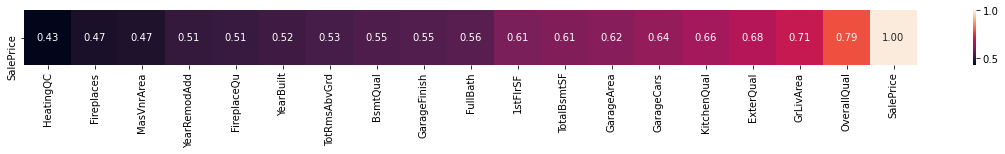

In [128]:
# Draw heatmap for columns with high correlation.
plt.figure(figsize=(20,1))
sns.heatmap(corrs[corrs >= 0.4].to_frame().T, annot=True, fmt='.2f')
plt.show()

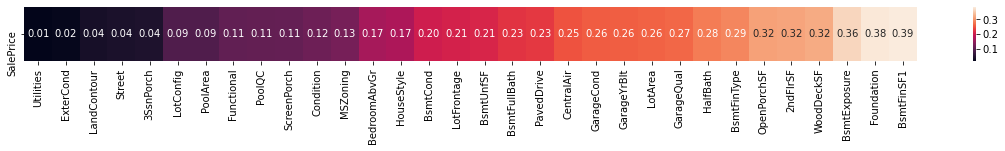

In [129]:
# Draw heatmap for columns with low correlation.
plt.figure(figsize=(20,1))
sns.heatmap(corrs[(corrs >= 0) & (corrs < 0.4)].to_frame().T, annot=True, fmt='.2f')
plt.show()

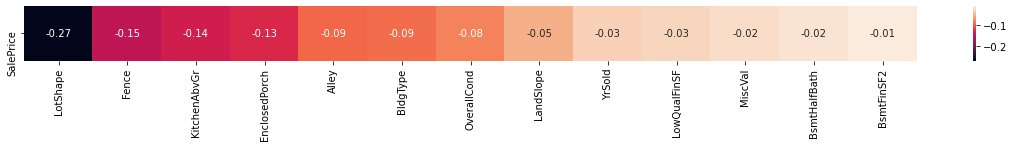

In [130]:
# Draw heatmap for columns with negative correlation.
plt.figure(figsize=(20,1))
sns.heatmap(corrs[corrs < 0].to_frame().T, annot=True, fmt='.2f')
plt.show()

## 3. Build models

### 3.1 Limited linear regression

In [131]:
# Separate output from input (using only columns with higher correlation).
X = train_data[corrs[corrs >= 0.4].index].drop('SalePrice', axis=1)
y = train_data['SalePrice'].copy()

# Separate data into training and testing subsets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=324)

In [132]:
# Create and train a classifier using linear regression (without the neighborhood).
linear_regression_l = LinearRegression()
linear_regression_l.fit(X_train, y_train)

# Make predictions.
y_pred = linear_regression_l.predict(X_test)

# Check the accuracy of the predictions.
MSE = np.mean((y_pred - y_test) ** 2)
RMSE = np.sqrt(MSE)
price_mean = np.mean(y_test)
print('Variance score: %.4f' % linear_regression_l.score(X_test, y_test))
print("Mean squared error: %.0f" % MSE)
print("Root mean squared error: %.0f" % RMSE)
print("Coefficient of variation: %.4f" % (RMSE / price_mean))

Variance score: 0.7764
Mean squared error: 1286855023
Root mean squared error: 35873
Coefficient of variation: 0.2015


### 3.2 Full linear regression

In [133]:
# Separate output from input (using all columns).
X = train_data.drop('SalePrice', axis=1)
y = train_data['SalePrice'].copy()

# Separate data into training and testing subsets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=324)

In [134]:
# Create and train a classifier using linear regression (without the neighborhood).
linear_regression_f = LinearRegression()
linear_regression_f.fit(X_train, y_train)

# Make predictions.
y_pred = linear_regression_f.predict(X_test)

# Check the accuracy of the predictions.
MSE = np.mean((y_pred - y_test) ** 2)
RMSE = np.sqrt(MSE)
price_mean = np.mean(y_test)
print('Variance score: %.4f' % linear_regression_f.score(X_test, y_test))
print("Mean squared error: %.0f" % MSE)
print("Root mean squared error: %.0f" % RMSE)
print("Coefficient of variation: %.4f" % (RMSE / price_mean))

Variance score: 0.8015
Mean squared error: 1142145647
Root mean squared error: 33796
Coefficient of variation: 0.1899


## 4. Make predictions

In [135]:
# Make the predictions using the simple linear regression.
test_data = sanitize_data(test_data_raw)
test_predictions = linear_regression_f.predict(test_data)

# Generate the submission file (to be uploaded to Kaggle).
output = pd.DataFrame({'Id': test_data_raw.Id, 'SalePrice': test_predictions})
output.to_csv('my_submission.csv', index=False)
print("The submission was successfully saved!")

The submission was successfully saved!
